In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

2023-09-27 10:47:14.999491: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-09-27 10:47:31--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.163.187, 172.217.160.155, 142.250.195.187, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.163.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  1.35MB/s    in 66s     

2023-09-27 10:48:38 (1.27 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [5]:
def create_pre_trained_model(local_weights_file):
    pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 
    pre_trained_model.load_weights(local_weights_file)

    for layer in pre_trained_model.layers:
        layer.trainable = False


    return pre_trained_model

In [6]:
pre_trained_model = create_pre_trained_model(local_weights_file)

pre_trained_model.summary()

2023-09-27 10:49:10.602943: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-27 10:49:10.603373: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [7]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


In [8]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.85):
      print("\nReached 85.0% accuracy so cancelling training!")
      self.model.stop_training = True

In [9]:
train_dir = 'images/train'
validation_dir = 'images/validation'

In [10]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    train_datagen = ImageDataGenerator( rescale = 1.0/255. )
    train_generator = train_datagen.flow_from_directory(directory=train_dir,                                                  
                                                      class_mode='categorical',
                                                      target_size=(150, 150))
    validation_datagen = ImageDataGenerator ( rescale = 1.0/255. )
    validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,                                                           
                                                                class_mode='categorical',
                                                                target_size=(150, 150))
    return train_generator, validation_generator

In [11]:
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [12]:
# GRADED FUNCTION: output_of_last_layer
def output_of_last_layer(pre_trained_model):
    last_desired_layer = pre_trained_model.get_layer('mixed7')
    print('last layer output shape: ', last_desired_layer.output_shape)
    last_output = last_desired_layer.output
    print('last layer output: ', last_output)
    return last_output

In [13]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [16]:
def create_final_model(pre_trained_model, last_output):
    x = layers.Flatten()(last_output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(.2)(x) 
    x = layers.Dense(7, activation='softmax')(x)     
    model = Model(pre_trained_model.input, x)
    model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
    return model

In [17]:
model = create_final_model(pre_trained_model, last_output)


total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 28,246,951 total parameters in this model.
There are 19,271,687 trainable parameters in this model.


In [19]:
callbacks = myCallback()

In [20]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 10,
                    verbose = 1,
                    callbacks=callbacks)

Epoch 1/10
  2/901 [..............................] - ETA: 48s - loss: 2.1276 - accuracy: 0.2812 

2023-09-27 10:54:34.896527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


901/901 [==============================] - ETA: 0s - loss: 1.3849 - accuracy: 0.4908

2023-09-27 10:55:24.324890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-09-27 10:55:24.661728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


901/901 [==============================] - 60s 67ms/step - loss: 1.3849 - accuracy: 0.4908 - val_loss: 1.2041 - val_accuracy: 0.5628
Epoch 2/10
901/901 [==============================] - 57s 63ms/step - loss: 1.1351 - accuracy: 0.5847 - val_loss: 1.2594 - val_accuracy: 0.5379
Epoch 3/10
901/901 [==============================] - 58s 65ms/step - loss: 1.0154 - accuracy: 0.6299 - val_loss: 1.1707 - val_accuracy: 0.5812
Epoch 4/10
901/901 [==============================] - 58s 65ms/step - loss: 0.9297 - accuracy: 0.6650 - val_loss: 1.1414 - val_accuracy: 0.5879
Epoch 5/10
901/901 [==============================] - 58s 65ms/step - loss: 0.8543 - accuracy: 0.6931 - val_loss: 1.1993 - val_accuracy: 0.5821
Epoch 6/10
901/901 [==============================] - 58s 64ms/step - loss: 0.7866 - accuracy: 0.7204 - val_loss: 1.1517 - val_accuracy: 0.6073
Epoch 7/10
901/901 [==============================] - 60s 66ms/step - loss: 0.7280 - accuracy: 0.7377 - val_loss: 1.2233 - val_accuracy: 0.5984
Epo

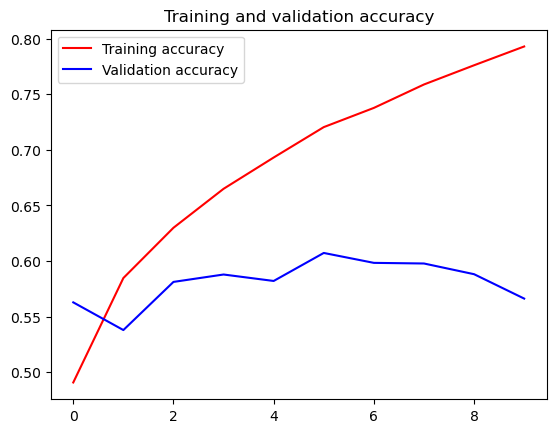

<Figure size 640x480 with 0 Axes>

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()